# Express sklearn pipeline as codeflare pipeline

Reference: https://scikit-learn.org/stable/auto_examples/compose/plot_digits_pipe.html#sphx-glr-auto-examples-compose-plot-digits-pipe-py


In [1]:
%matplotlib inline


# Pipelining: chaining a PCA and a logistic regression

The PCA does an unsupervised dimensionality reduction, while the logistic
regression does the prediction.

We use a GridSearchCV to set the dimensionality of the PCA


Automatically created module for IPython interactive environment
Best parameter (CV score=0.920):
{'logistic__C': 0.046415888336127774, 'pca__n_components': 45}


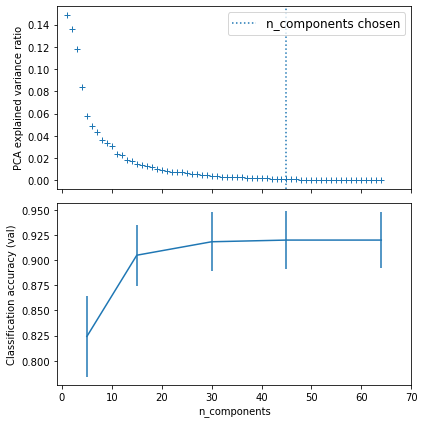

In [50]:
print(__doc__)


# Code source: Gaël Varoquaux
# Modified for documentation by Jaques Grobler
# License: BSD 3 clause


import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn import datasets
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV


# Define a pipeline to search for the best combination of PCA truncation
# and classifier regularization.
pca = PCA()
# set the tolerance to a large value to make the example faster
logistic = LogisticRegression(max_iter=10000, tol=0.1)
pipe = Pipeline(steps=[('pca', pca), ('logistic', logistic)])

X_digits, y_digits = datasets.load_digits(return_X_y=True)

# Parameters of pipelines can be set using ‘__’ separated parameter names:
param_grid = {
    'pca__n_components': [5, 15, 30, 45, 64],
    'logistic__C': np.logspace(-4, 4, 4),
}
search = GridSearchCV(pipe, param_grid, n_jobs=-1)
search.fit(X_digits, y_digits)
print("Best parameter (CV score=%0.3f):" % search.best_score_)
print(search.best_params_)

# Plot the PCA spectrum
pca.fit(X_digits)

fig, (ax0, ax1) = plt.subplots(nrows=2, sharex=True, figsize=(6, 6))
ax0.plot(np.arange(1, pca.n_components_ + 1),
         pca.explained_variance_ratio_, '+', linewidth=2)
ax0.set_ylabel('PCA explained variance ratio')

ax0.axvline(search.best_estimator_.named_steps['pca'].n_components,
            linestyle=':', label='n_components chosen')
ax0.legend(prop=dict(size=12))

# For each number of components, find the best classifier results
results = pd.DataFrame(search.cv_results_)

components_col = 'param_pca__n_components'
best_clfs = results.groupby(components_col).apply(
    lambda g: g.nlargest(1, 'mean_test_score'))

best_clfs.plot(x=components_col, y='mean_test_score', yerr='std_test_score',
               legend=False, ax=ax1)
ax1.set_ylabel('Classification accuracy (val)')
ax1.set_xlabel('n_components')

plt.xlim(-1, 70)

plt.tight_layout()
plt.show()

Automatically created module for IPython interactive environment


2021-06-09 12:24:00,587	INFO services.py:1267 -- View the Ray dashboard at http://127.0.0.1:8267


0.9226679046734757
{'pca__3': {'copy': True, 'iterated_power': 'auto', 'n_components': 45, 'random_state': None, 'svd_solver': 'auto', 'tol': 0.0, 'whiten': False}, 'logistic__1': {'C': 0.046415888336127774, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 10000, 'multi_class': 'auto', 'n_jobs': None, 'penalty': 'l2', 'random_state': None, 'solver': 'lbfgs', 'tol': 0.1, 'verbose': 0, 'warm_start': False}}
0.9260058805323429
{'pca__4': {'copy': True, 'iterated_power': 'auto', 'n_components': 64, 'random_state': None, 'svd_solver': 'auto', 'tol': 0.0, 'whiten': False}, 'logistic__1': {'C': 0.046415888336127774, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 10000, 'multi_class': 'auto', 'n_jobs': None, 'penalty': 'l2', 'random_state': None, 'solver': 'lbfgs', 'tol': 0.1, 'verbose': 0, 'warm_start': False}}


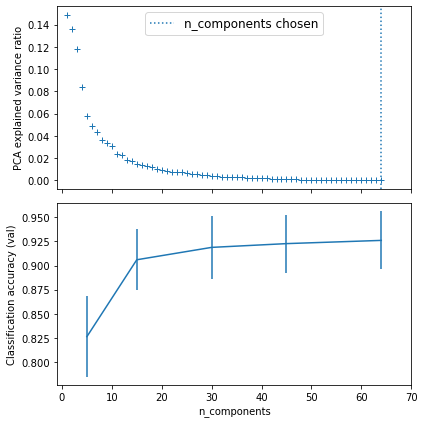

In [51]:
import codeflare.pipelines.Datamodel as dm
import codeflare.pipelines.Runtime as rt
from codeflare.pipelines.Datamodel import Xy
from codeflare.pipelines.Datamodel import XYRef
from codeflare.pipelines.Runtime import ExecutionType

print(__doc__)

# Code source: Gaël Varoquaux
# Modified for documentation by Jaques Grobler
# Modified for codeflare pipeline by Yuan-Chi Chang
# License: Same as original code creator


import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn import datasets
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn import datasets
from sklearn.model_selection import KFold

import ray
ray.shutdown()
ray.init()

X_digits, y_digits = datasets.load_digits(return_X_y=True)

pca = PCA()
# set the tolerance to a large value to make the example faster
logistic = LogisticRegression(max_iter=10000, tol=0.1)

pipeline = dm.Pipeline()
node_pca = dm.EstimatorNode('pca', pca)
node_logistic = dm.EstimatorNode('logistic', logistic)

pipeline.add_edge(node_pca, node_logistic)

# input to pipeline
pipeline_input = dm.PipelineInput()
pipeline_input.add_xy_arg(node_pca, dm.Xy(X_digits, y_digits))

# param_grid
param_grid = {
        'pca__n_components': [5, 15, 30, 45, 64],
        'logistic__C': np.logspace(-4, 4, 4),
    }

pipeline_param = dm.PipelineParam.from_param_grid(param_grid)

# default KFold for grid search
k = 5
kf = KFold(k)

# execute CF pipeplie grid_search_cv
result = rt.grid_search_cv(kf, pipeline, pipeline_input, pipeline_param)

import statistics

# pick the best mean' and best pipeline
best_pipeline = None
best_mean_scores = 0.0
best_n_components = 0

df = pd.DataFrame(columns =('n_components', 'mean_test_score', 'std_test_score'))

for cv_pipeline, scores in result.items():
    mean = statistics.mean(scores)
    std = statistics.stdev(scores)
    n_components = 0
    params = {}
    # get the 'n_components' value of the PCA in this cv_pipeline
    for node_name, node in cv_pipeline.get_nodes().items():
        params[node_name] = node.get_estimator().get_params()
        if 'n_components' in params[node_name]:
            n_components = params[node_name]['n_components']
    assert(n_components > 0)
    df = df.append({'n_components' : n_components, 'mean_test_score' : mean, 'std_test_score' : std}, ignore_index=True)
    if mean > 0.92:
        print(mean)
        print(str(params))
        
    if mean > best_mean_scores:
        best_pipeline = cv_pipeline
        best_mean_scores = mean
        best_n_components = n_components
        

# Plot the PCA spectrum
pca.fit(X_digits)

fig, (ax0, ax1) = plt.subplots(nrows=2, sharex=True, figsize=(6, 6))
ax0.plot(np.arange(1, pca.n_components_ + 1),
         pca.explained_variance_ratio_, '+', linewidth=2)
ax0.set_ylabel('PCA explained variance ratio')

# plot a vertical line with the n_components chosen from the best_pipeline

ax0.axvline(best_n_components,
            linestyle=':', label='n_components chosen')

ax0.legend(prop=dict(size=12))

# For each number of components, find the best classifier results

components_col = 'n_components'
best_clfs = df.groupby(components_col).apply(
    lambda g: g.nlargest(1, 'mean_test_score'))


best_clfs.plot(x=components_col, y='mean_test_score', yerr='std_test_score',
               legend=False, ax=ax1)
ax1.set_ylabel('Classification accuracy (val)')
ax1.set_xlabel('n_components')

plt.xlim(-1, 70)

plt.tight_layout()
plt.show()

ray.shutdown()